<a href="https://colab.research.google.com/github/caiocfpeixoto/VGG16_RANDOM_FOREST/blob/main/VGG16_%26_Random_Forest_V1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import de pacotes necessários

In [ ]:
!pip install split-folders

In [ ]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import os
from PIL import Image

import matplotlib.pyplot as plt
import glob

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, MaxPooling2D

from keras.applications import VGG16

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from keras.utils import  to_categorical
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import splitfolders


Conexão com Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Criando divisão ***train(80%)*** e ***test(20%)*** de forma Randomica

In [ ]:

# Diretório de origem que contém as imagens
diretorio_origem = '/content/drive/MyDrive/Celulas Cervicais_V1.1/'

# Diretório de destino para as imagens de treinamento e teste
diretorio_destino = '/content/drive/MyDrive/Celulas Cervicais_V1.1_seed_42/'

# Use splitfolders para dividir as imagens em treinamento e teste (80% e 20%)
splitfolders.ratio(diretorio_origem, output=diretorio_destino, seed=42, ratio=(0.8, 0.2))

print("Divisão concluída.")


Copying files: 11469 files [07:19, 26.10 files/s]

Divisão concluída.


Dataset dividido em ***Train*** e ***Test***. Cada um diretórios é dividido em duas categorias:


*   POSITIVA
*   NEGATIVA

A função abaixo percorre o diretório e cria labels para as imagens:

In [ ]:
SIZE = 100
def datafunc(datadir):
    images = []
    labels = []
    file_names = []
    for dir_path in glob.glob(datadir):
        label = dir_path.split('/')[-1]
        print(label)
        for img_path in glob.glob(os.path.join(dir_path, '*.tif')):
            try:
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (SIZE, SIZE))
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                file_name = os.path.basename(img_path)
                file_names.append(file_name)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(e)

    return np.array(images), np.array(labels), np.array(file_names)

Interando cada diretório e criando as respectivas labels

In [ ]:
train_images, train_labels, train_images_names = datafunc('/content/drive/MyDrive/Celulas Cervicais_V1.1_seed_42/train/*')
test_images, test_labels, test_images_names = datafunc('/content/drive/MyDrive/Celulas Cervicais_V1.1_seed_42/test/*')

POSITIVA
NEGATIVA
POSITIVA
NEGATIVA


Demonstrar os dados em gráficos

Text(0.5, 1.0, 'Test data')

<Figure size 2000x500 with 0 Axes>

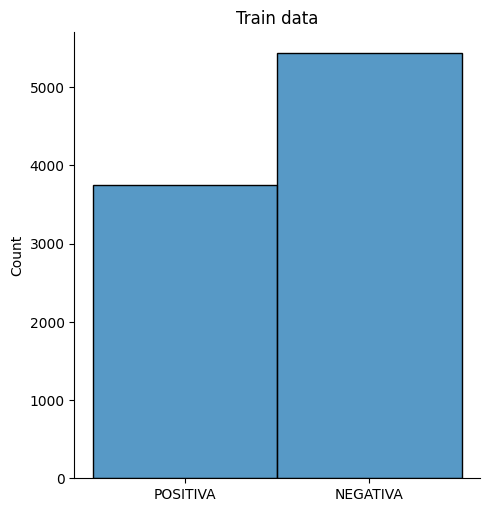

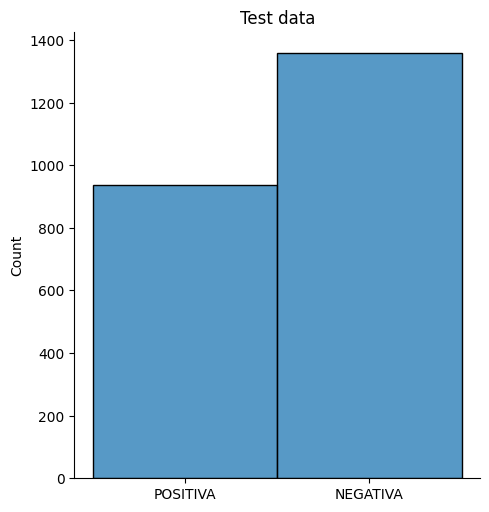

In [ ]:
plt.figure(figsize=(20,5))

sns.displot(train_labels)
plt.title('Train data')

sns.displot(test_labels)
plt.title('Test data')

Verificando a quantidade de ocorrências das labels, será necessário fazer um downshape dos dados pois a quantidade está desbalanceada

- Verificando Train

In [ ]:
df = pd.DataFrame({'label': train_labels, 'images': list(train_images_names), 'path': list(train_images)}, columns=['label', 'images', 'path'])

count_class_0, count_class_1 = df.label.value_counts()

df_class_0 = df[df['label'] == 'NEGATIVA']
df_class_1 = df[df['label'] == 'POSITIVA']

print('NEGATIVA =', count_class_0)
print('POSITIVA =', count_class_1)
display(df)


NEGATIVA = 5432
POSITIVA = 3743


,label,images,path
0,POSITIVA,c7c3f56a4d110b49099830b0f65251a3_497_423.tif,"[[[206, 232, 224], [202, 228, 221], [201, 226,..."
1,POSITIVA,c7adf1972424f069b6355c500962722f_612_219.tif,"[[[206, 218, 235], [205, 219, 234], [193, 209,..."
2,POSITIVA,c7c3f56a4d110b49099830b0f65251a3_479_462.tif,"[[[207, 236, 216], [205, 233, 221], [203, 230,..."
3,POSITIVA,c7adf1972424f069b6355c500962722f_522_960.tif,"[[[22, 30, 63], [29, 40, 80], [47, 65, 101], [..."
4,POSITIVA,c63289c59bca91f80b2dde9ac013cc57_142_227.tif,"[[[40, 40, 104], [41, 40, 103], [44, 40, 102],..."
...,...,...,...
9170,NEGATIVA,16032768fe56bbb933730762d726d263_812_637.tif,"[[[228, 148, 121], [226, 153, 123], [238, 150,..."
9171,NEGATIVA,16032768fe56bbb933730762d726d263_302_495.tif,"[[[218, 135, 99], [221, 127, 94], [224, 127, 9..."
9172,NEGATIVA,16032768fe56bbb933730762d726d263_87_1203.tif,"[[[233, 242, 254], [243, 226, 221], [218, 200,..."
9173,NEGATIVA,16032768fe56bbb933730762d726d263_627_792.tif,"[[[209, 165, 175], [221, 171, 172], [223, 175,..."


- Verificando test

In [ ]:
df2 = pd.DataFrame({'label': test_labels, 'images': list(test_images_names), 'path': list(test_images)}, columns=['label', 'images', 'path'])

t_count_class_0, t_count_class_1 = df2.label.value_counts()

df2_class_0 = df2[df2['label'] == 'NEGATIVA']
df2_class_1 = df2[df2['label'] == 'POSITIVA']

print('NEGATIVA =', t_count_class_0)
print('POSITIVA =', t_count_class_1)
display(df2)

NEGATIVA = 1358
POSITIVA = 936


,label,images,path
0,POSITIVA,00b1e59ebc3e7be500ef7548207d44e2_485_663.tif,"[[[215, 125, 91], [215, 117, 99], [207, 112, 1..."
1,POSITIVA,011fda505d7e4af4b8cc57545343624d_595_708.tif,"[[[194, 184, 212], [221, 194, 208], [219, 206,..."
2,POSITIVA,00b1e59ebc3e7be500ef7548207d44e2_407_752.tif,"[[[146, 62, 66], [129, 60, 66], [128, 57, 75],..."
3,POSITIVA,040722a73af21747a3b66a8d69a235d0_417_1065.tif,"[[[232, 190, 179], [247, 201, 183], [254, 207,..."
4,POSITIVA,03f5d5ec88161b9365bea549d7ce92cd_285_170.tif,"[[[159, 100, 102], [156, 98, 100], [149, 90, 9..."
...,...,...,...
2289,NEGATIVA,4bae321eaa4fedb2a75bf5c53b14b4f4_890_977.tif,"[[[239, 227, 231], [237, 228, 233], [228, 222,..."
2290,NEGATIVA,4dbb52e87bc98d0d5a10cc0dc05fdc3f_259_379.tif,"[[[151, 151, 178], [147, 146, 175], [151, 151,..."
2291,NEGATIVA,4a34b60331799fdc99ccce2ac9531a9d_488_472.tif,"[[[196, 132, 99], [196, 127, 92], [191, 121, 8..."
2292,NEGATIVA,4f8e654e9c41b941ef6ced7a6b833917_678_513.tif,"[[[186, 141, 132], [188, 139, 119], [166, 132,..."


Dados balanceados

Random under-sampling:
NEGATIVA    3743
POSITIVA    3743
Name: label, dtype: int64


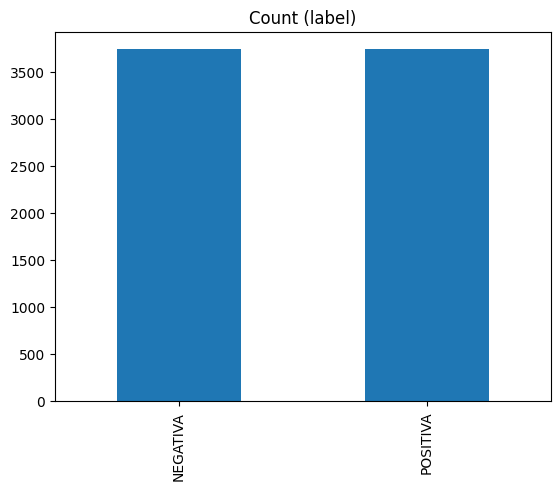

In [ ]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.label.value_counts())

df_test_under.label.value_counts().plot(kind='bar', title='Count (label)');

Convertendo Dataframe para array

In [ ]:
t_images = []
for img in df_test_under['path']:
    img = Image.fromarray(img)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    t_images.append(img)
t_images = np.array(t_images)
train_labels = np.array(df_test_under['label'])

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

x_train, y_train, x_test, y_test = t_images, train_labels_encoded, test_images, test_labels_encoded
x_train, x_test = x_train / 255.0, x_test / 255.0 #scaling the data

In [ ]:
VGG_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (SIZE, SIZE, 3))

for layer in VGG_model.layers:
    layer.trainable = False

VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [ ]:
feature_extractor = VGG_model.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_rf = features

234/234 [==============================] - 901s 4s/step


In [ ]:
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)

RF_model.fit(X_rf, y_train)

X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

prediction_RF = RF_model.predict(X_test_features)

72/72 [==============================] - 296s 4s/step


Accuracy = 0.7602441150828247
Recall = 0.9017094017094017
Precision = 0.6482334869431644
Kappa = 0.5321193727870511


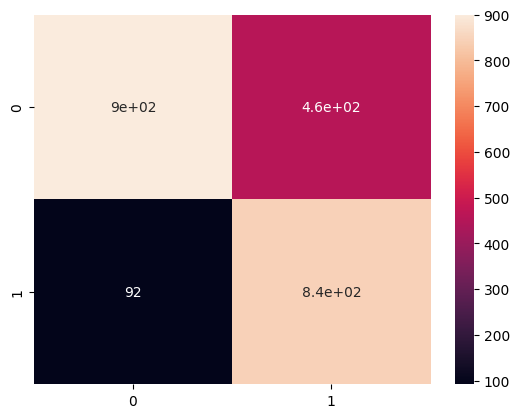

In [ ]:
cm = confusion_matrix(y_test, prediction_RF)
sns.heatmap(cm, annot = True)

tp, fp, fn, tn = cm.ravel()

accurary = metrics.accuracy_score(y_test, prediction_RF)
recall = metrics.recall_score(y_test, prediction_RF)
precision = metrics.precision_score(y_test, prediction_RF)
kappa = metrics.cohen_kappa_score(y_test, prediction_RF)

print('Accuracy =', accurary)
print("Recall =", recall)
print("Precision =", precision)
print("Kappa =", kappa) # adicionado o índice  kappa

vetor_resultados = []